# Cross-match to SIMBAD AGN in the DECam DDF COSMOS & ELAIS fields

Previous work derived catalogs of AGN from SIMBAD, for the 2021 data only.

Use these same catalogs (as the field areas have not changed) and cross-match to the
candidates with nightly-epoch light curves being released with Paper II.

## Set up and read in data

All the files have headers which explain the columns.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
from astropy.coordinates import SkyCoord
import astropy.units as u

import collections
from astropy.io import ascii

Plotting parameters for nightly-epoch light curves.

In [2]:
all_filters = ['g','r','i']
all_fcolors = ['green','red','blue']
all_fshapes = ['o','s','^']
all_fsizes  = [5, 5, 7]

Candidate coordinates.

In [3]:
fnm = '../../all_nightly_epochs_files/candidate_coordinates.dat'
cand_id = np.loadtxt(fnm, dtype='str', usecols=(0))
cand_ra = np.loadtxt(fnm, dtype='float', usecols=(1))
cand_dec = np.loadtxt(fnm, dtype='float', usecols=(2))
del fnm

Light curve data for candidates.

In [4]:
fnm = '../../all_nightly_epochs_files/candidate_lightcurves.dat'
candLC_field = np.loadtxt(fnm, dtype='str', usecols=(0))
candLC_candid = np.loadtxt(fnm, dtype='str', usecols=(1))
candLC_caldate = np.loadtxt(fnm, dtype='str', usecols=(2))
candLC_mjd = np.loadtxt(fnm, dtype='float', usecols=(3))
candLC_filter = np.loadtxt(fnm, dtype='str', usecols=(4))
candLC_Nobj = np.loadtxt(fnm, dtype='int', usecols=(5))
candLC_mag = np.loadtxt(fnm, dtype='float', usecols=(6))
candLC_mage = np.loadtxt(fnm, dtype='float', usecols=(7))
candLC_mrb = np.loadtxt(fnm, dtype='float', usecols=(8))
candLC_lef = np.loadtxt(fnm, dtype='float', usecols=(9))
del fnm

In [5]:
fnm = '../../all_nightly_epochs_files/candidate_lightcurve_parameters.dat'
paramLC_field = np.loadtxt(fnm, dtype='str', usecols=(0))
paramLC_candid = np.loadtxt(fnm, dtype='str', usecols=(1))
paramLC_tspan = np.loadtxt(fnm, dtype='float', usecols=(2))
paramLC_tspan_g = np.loadtxt(fnm, dtype='float', usecols=(3))
paramLC_tspan_r = np.loadtxt(fnm, dtype='float', usecols=(4))
paramLC_tspan_i = np.loadtxt(fnm, dtype='float', usecols=(5))
paramLC_minmag = np.loadtxt(fnm, dtype='float', usecols=(6))
paramLC_minmag_g = np.loadtxt(fnm, dtype='float', usecols=(7))
paramLC_minmag_r = np.loadtxt(fnm, dtype='float', usecols=(8))
paramLC_minmag_i = np.loadtxt(fnm, dtype='float', usecols=(9))
paramLC_amp = np.loadtxt(fnm, dtype='float', usecols=(10))
paramLC_amp_g = np.loadtxt(fnm, dtype='float', usecols=(11))
paramLC_amp_r = np.loadtxt(fnm, dtype='float', usecols=(12))
paramLC_amp_i = np.loadtxt(fnm, dtype='float', usecols=(13))
paramLC_neps = np.loadtxt(fnm, dtype='int', usecols=(14))
paramLC_neps_g = np.loadtxt(fnm, dtype='int', usecols=(15))
paramLC_neps_r = np.loadtxt(fnm, dtype='int', usecols=(16))
paramLC_neps_i = np.loadtxt(fnm, dtype='int', usecols=(17))
del fnm

Various lists of AGN from SIMBAD.

RA and Dec are both in decimal degrees.

In [6]:
fnm = 'all_agn_catalog_results/COSMOS_result.txt'
cosmos_id = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={0}, dtype='str')
cosmos_ra = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={1}, dtype='float')
cosmos_dec = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={2}, dtype='float')
cosmos_type = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={3}, dtype='str')
print('cosmos ', len(cosmos_id))
del fnm

fnm = 'all_agn_catalog_results/COSMOS2015_result.txt'
cosmos15_id = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={0}, dtype='str')
cosmos15_ra = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={1}, dtype='float')
cosmos15_dec = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={2}, dtype='float')
cosmos15_type = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={3}, dtype='str')
print('cosmos15 ', len(cosmos15_id))
del fnm

fnm = 'all_agn_catalog_results/ACS-GC_result.txt'
acs_id = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={0}, dtype='str')
acs_ra = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={1}, dtype='float')
acs_dec = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={2}, dtype='float')
acs_type = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={3}, dtype='str')
print('acs ', len(acs_id))
del fnm

fnm = 'all_agn_catalog_results/ELAIS_result.txt'
elais_id = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={0}, dtype='str')
elais_ra = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={1}, dtype='float')
elais_dec = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={2}, dtype='float')
elais_type = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={3}, dtype='str')
print('elais ', len(elais_id))
del fnm

fnm = 'all_agn_catalog_results/ESIS_result.txt'
esis_id = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={0}, dtype='str')
esis_ra = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={1}, dtype='float')
esis_dec = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={2}, dtype='float')
esis_type = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={3}, dtype='str')
print('esis ', len(esis_id))
del fnm

fnm = 'all_agn_catalog_results/SWIRE_result.txt'
swire_id = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={0}, dtype='str')
swire_ra = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={1}, dtype='float')
swire_dec = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={2}, dtype='float')
swire_type = np.loadtxt(fnm, skiprows=2, delimiter='|', usecols={3}, dtype='str')
print('swire ', len(swire_id))
del fnm

cosmos  55623
cosmos15  3696
acs  2692
elais  1867
esis  347
swire  209


In [7]:
total = len(cosmos_id) + len(cosmos15_id) + len(acs_id) + len(elais_id) + len(esis_id) + len(swire_id)
print(total)
del total

64434


Consolidate. There will be duplicates but that's OK.

In [8]:
tmp_id = []
tmp_ra = []
tmp_dec = []
tmp_type = []
tmp_cat = []

for i in range(len(cosmos_id)):
    tmp_id.append(cosmos_id[i])
    tmp_ra.append(cosmos_ra[i])
    tmp_dec.append(cosmos_dec[i])
    tmp_type.append(cosmos_type[i])
    tmp_cat.append('cosmos')

for i in range(len(cosmos15_id)):
    tmp_id.append(cosmos15_id[i])
    tmp_ra.append(cosmos15_ra[i])
    tmp_dec.append(cosmos15_dec[i])
    tmp_type.append(cosmos15_type[i])
    tmp_cat.append('cosmos15')

for i in range(len(acs_id)):
    tmp_id.append(acs_id[i])
    tmp_ra.append(acs_ra[i])
    tmp_dec.append(acs_dec[i])
    tmp_type.append(acs_type[i])
    tmp_cat.append('acs')

for i in range(len(elais_id)):
    tmp_id.append(elais_id[i])
    tmp_ra.append(elais_ra[i])
    tmp_dec.append(elais_dec[i])
    tmp_type.append(elais_type[i])
    tmp_cat.append('elais')

for i in range(len(esis_id)):
    tmp_id.append(esis_id[i])
    tmp_ra.append(esis_ra[i])
    tmp_dec.append(esis_dec[i])
    tmp_type.append(esis_type[i])
    tmp_cat.append('esis')

for i in range(len(swire_id)):
    tmp_id.append(swire_id[i])
    tmp_ra.append(swire_ra[i])
    tmp_dec.append(swire_dec[i])
    tmp_type.append(swire_type[i])
    tmp_cat.append('swire')

agn_id = np.asarray(tmp_id, dtype='str')
agn_ra = np.asarray(tmp_ra, dtype='float')
agn_dec = np.asarray(tmp_dec, dtype='float')
agn_type = np.asarray(tmp_type, dtype='str')
agn_cat = np.asarray(tmp_cat, dtype='str')

del tmp_id, tmp_ra, tmp_dec, tmp_type, tmp_cat
del cosmos_id, cosmos_ra, cosmos_dec, cosmos_type
del cosmos15_id, cosmos15_ra, cosmos15_dec, cosmos15_type
del acs_id, acs_ra, acs_dec, acs_type
del elais_id, elais_ra, elais_dec, elais_type
del esis_id, esis_ra, esis_dec, esis_type
del swire_id, swire_ra, swire_dec, swire_type

There's going to be cross-matching, so use `astropy` `SkyCoord`.

In [9]:
agn_coords = SkyCoord(agn_ra, agn_dec, unit='deg')

In [10]:
cand_coords = SkyCoord(cand_ra, cand_dec, unit='deg')

## Cross-match

The AGN are all within the boundaries of the ELAIS or COSMOS fields.

Record the match indices and also the number of matches.

For candidates, record the minimum separation and the stadard deviation in separations.
The latter is always very small showing multiple matches are just the result of duplication.

In [11]:
agn_cindex = np.zeros(len(agn_id), dtype='int') - 1
agn_nmatches = np.zeros(len(agn_id), dtype='int')

cand_aindex = np.zeros(len(cand_id), dtype='int') - 1
cand_minsep = np.zeros(len(cand_id), dtype='float')
cand_stdsep = np.zeros(len(cand_id), dtype='float')
cand_nmatches = np.zeros(len(cand_id), dtype='int')

In [12]:
%%time

agn_candidates = np.array([])

for c, cand in enumerate(cand_id):
    tx = np.where((np.abs(agn_ra - cand_ra[c])*3600.0 < 10.0) & 
                  (np.abs(agn_dec - cand_dec[c])*3600.0 < 10.0))[0]
    sep = cand_coords[c].separation(agn_coords[tx]).arcsec
    sx = np.where(sep < 2.)[0]
    if len(sx) > 0:
        mx = np.argmin(sep)
        cand_aindex[c] = tx[sx[mx]]
        cand_nmatches[c] = len(sx)
        cand_minsep[c] = sep[sx[mx]]
        cand_stdsep[c] = np.std(sep[sx])
        del mx
        agn_candidates = np.append(agn_candidates,cand_id[c])
    agn_cindex[tx[sx]] = c
    agn_nmatches[tx[sx]] += 1
    del sep, tx, sx

CPU times: user 1.79 s, sys: 58.1 ms, total: 1.85 s
Wall time: 1.86 s


In [13]:
tx = np.where(cand_nmatches == 1)[0]
print('candidates with one match: ', len(tx))
del tx
print(' ')

tx = np.where(cand_nmatches > 1)[0]
print('candidates with multiple matches: ', len(tx))

mean_stdsep = np.mean(cand_stdsep[tx])
print('mean stdsep ', mean_stdsep)
ttx = np.where(cand_stdsep[tx] > mean_stdsep * 3)[0]
print('how many times was the std in separations large-ish?')
print(len(ttx), cand_stdsep[tx[ttx]])
del tx
print('the vast majority of the time, multiple matches are just to duplicates')
print(' ')

tx = np.where(cand_nmatches >= 1)[0]
print('candidates with one or more matches: ', len(tx))

values, counts = np.unique(agn_type[cand_aindex[tx]], return_counts=True)
for v, val in enumerate(values):
    print(val, counts[v])

savefile = 'crossmatch_AGN_types.txt'
dictionary = collections.OrderedDict()
dictionary['id']       = cand_id[tx]
dictionary['agn_type'] = agn_type[cand_aindex[tx]]
ascii.write(dictionary, savefile, format="fixed_width", delimiter=' ', overwrite=True)

del tx

candidates with one match:  109
 
candidates with multiple matches:  357
mean stdsep  0.001335834128174628
how many times was the std in separations large-ish?
2 [0.21771448 0.2591783 ]
the vast majority of the time, multiple matches are just to duplicates
 
candidates with one or more matches:  466
"AGN"     119
"BLL"     2
"QSO"     325
"Sy1"     18
"Sy2"     1
"SyG"     1


In [14]:
tx = np.where(agn_nmatches == 1)[0]
print('agn with one match: ', len(tx))
del tx
tx = np.where(agn_nmatches > 1)[0]
print('agn with multiple matches: ', len(tx))
del tx
tx = np.where(agn_nmatches >= 1)[0]
print('agn with one or more matches: ', len(tx))
del tx

agn with one match:  4112
agn with multiple matches:  242
agn with one or more matches:  4354


## Identify some AGN-like variable candidates, explore light curve

Some loose constraints on what "AGN-like" variability means.

In [15]:
min_tspan = 720
max_minmag = 23
min_amp = 0.2
min_neps = 40
tx = np.where(((paramLC_tspan_g >= min_tspan) | (paramLC_tspan_r >= min_tspan) | (paramLC_tspan_i >= min_tspan)) &
              ((paramLC_minmag_g <= max_minmag) | (paramLC_minmag_r <= max_minmag) | (paramLC_minmag_i <= max_minmag)) & 
              ((paramLC_amp_g >= min_amp) | (paramLC_amp_r >= min_amp) | (paramLC_amp_i >= min_amp)) & 
              ((paramLC_neps_g >= min_neps) | (paramLC_neps_r >= min_neps) | (paramLC_neps_i >= min_neps)))[0]
del min_tspan, max_minmag, min_amp, min_neps
print(len(tx))

potential_agn = paramLC_candid[tx]
del tx

234


Identify candidates that vary like an AGN and are also matched to a catalog AGN.

Take one example of each and plot light curves.

In [16]:
cand_varagn = np.zeros(len(cand_id), dtype='int')
for c, cand in enumerate(cand_id):
    tx = np.where(cand == potential_agn)[0]
    if len(tx) == 1:
        cand_varagn[c] = 1
    del tx

tx = np.where((cand_nmatches >= 1) & (cand_varagn == 1))[0]

print('variable like and AGN and matched to known AGN: ', len(tx))

types = agn_type[cand_aindex[tx]]
values, counts = np.unique(types, return_counts=True)

tmp1 = []
tmp2 = []
for v, val in enumerate(values):
    print(val, counts[v])
    ttx = np.where(agn_type[cand_aindex[tx]] == val)[0]
    rx = np.random.choice(len(ttx), 1)
    tmp1.append(cand_id[tx[ttx[rx[0]]]])
    tmp2.append(val.strip().strip('"'))
    del rx
    if val.strip().strip('"') == 'QSO':
        rx = np.random.choice(len(ttx), 1)
        tmp1.append(cand_id[tx[ttx[rx[0]]]])
        tmp2.append(val.strip().strip('"'))
        del rx        
    del ttx
del tx

cand_of_int = np.asarray(tmp1, dtype='str')
cand_of_int_type = np.asarray(tmp2, dtype='str')
del tmp1, tmp2
del types, values

print(cand_of_int)
print(cand_of_int_type)

variable like and AGN and matched to known AGN:  121
"AGN"     13
"QSO"     103
"Sy1"     5
['DC21kpxs' 'DC21gux' 'DC21kree' 'DC21cgfio']
['AGN' 'QSO' 'QSO' 'Sy1']


Rearrange the order for the plot.

Note that rG = radio galaxy.

MLG side note: the first random batch was

`['DC21lau' 'DC21eov' 'DC21fll' 'DC21bsih' 'DC21rmv' 'DC21uur']`

`['AGN' 'QSO' 'QSO' 'Sy1' 'Sy2' 'rG']`


In [17]:
reorder_cand_of_int_type = np.asarray(['QSO', 'QSO', 'Sy1', 'AGN'], dtype='str')

tmp = []
tx = np.where(cand_of_int_type == 'QSO')[0]
tmp.append(cand_of_int[tx[0]])
tmp.append(cand_of_int[tx[1]])
del tx

tx = np.where(cand_of_int_type == 'Sy1')[0]
tmp.append(cand_of_int[tx[0]])
del tx

tx = np.where(cand_of_int_type == 'AGN')[0]
tmp.append(cand_of_int[tx[0]])
del tx

reorder_cand_of_int = np.asarray(tmp, dtype='str')
del tmp

print(reorder_cand_of_int)
print(reorder_cand_of_int_type)

['DC21gux' 'DC21kree' 'DC21cgfio' 'DC21kpxs']
['QSO' 'QSO' 'Sy1' 'AGN']


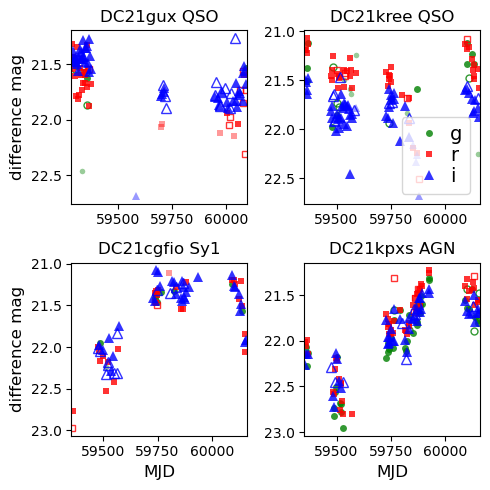

In [18]:
nrow = 2
ncol = 2
fig, ax = plt.subplots(nrow, ncol, figsize=(5, 5), sharex=False, sharey=False)

x = 0
for i in range(nrow):
    ax[i, 0].set_ylabel('difference mag', fontsize=12)
    for j in range(ncol):
        if x <= len(reorder_cand_of_int)-1:
            for f,filt in enumerate(all_filters):
                cx0 = np.where((candLC_candid == reorder_cand_of_int[x]) & \
                               (candLC_filter == filt) & (candLC_mrb > 0.4))[0]
                cx1 = np.where((candLC_candid == reorder_cand_of_int[x]) & \
                               (candLC_filter == filt) & (candLC_mrb <= 0.4) & (candLC_lef == 0))[0]
                cx2 = np.where((candLC_candid == reorder_cand_of_int[x]) & \
                               (candLC_filter == filt) & (candLC_mrb <= 0.4) & (candLC_lef == 1))[0]
                ax[i, j].plot(candLC_mjd[cx0], candLC_mag[cx0], 
                             all_fshapes[f], ms=all_fsizes[f], mew=0, alpha=0.8, color=all_fcolors[f], label=filt)
                ax[i, j].plot(candLC_mjd[cx1], candLC_mag[cx1], 
                             all_fshapes[f], ms=all_fsizes[f], mew=1, alpha=0.8, color='none', mec=all_fcolors[f])
                ax[i, j].plot(candLC_mjd[cx2], candLC_mag[cx2], 
                             all_fshapes[f], ms=all_fsizes[f]-1, mew=0, alpha=0.4, color=all_fcolors[f])
                del cx0, cx1, cx2

            cx = np.where((candLC_candid == reorder_cand_of_int[x]) & (candLC_lef == 0))[0]
            xmin = np.min(candLC_mjd[cx])
            xmax = np.max(candLC_mjd[cx])
            del cx
            ax[i, j].invert_yaxis()
            ax[i, j].set_xlim([xmin-5, xmax+5])
            del xmin, xmax
            cx = np.where(cand_of_int == reorder_cand_of_int[x])[0]
            ax[i, j].set_title(reorder_cand_of_int[x] + ' ' + reorder_cand_of_int_type[x])
            x += 1

ax[0, 1].legend(loc='best', labelspacing=0.1, handletextpad=0.1, fontsize=14)

for j in range(ncol):
    ax[nrow-1, j].set_xlabel('MJD', fontsize=12)

plt.tight_layout()
plt.savefig('agn_xmatch_lc.png')
plt.show()
del x